<h2>INSTALLAZIONE LIBRERIE</h2>

<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
Installazione librerie <strong>necessarie per il funzionamento</strong> del progetto:
</p>

In [1]:
pip install --quiet --upgrade pip scipy matplotlib wordcloud seaborn nltk scikit-learn plotly nbformat imbalanced-learn tqdm xgboost pillow tabulate

Note: you may need to restart the kernel to use updated packages.


<h2>IMPORTAZIONE LIBRERIE</h2>

In [2]:
# Calcolo e manipolazione dati
import numpy as np
import pandas as pd
from collections import Counter
import re
import string
import warnings

# NLP e Preprocessing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

# Gestione degli squilibri di classe
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Machine Learning e Modelli
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metriche di valutazione
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, log_loss, precision_recall_fscore_support, classification_report, accuracy_score, f1_score, precision_score, recall_score)
from tabulate import tabulate

# Utility
from sklearn.utils import resample
from tqdm import tqdm  # Barra di avanzamento
import time
import matplotlib.image as mpimg
from IPython.display import Image, display
from IPython.core.display import HTML
from sklearn.exceptions import ConvergenceWarning

# Visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)

# Ignorare avvisi
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter("ignore", ConvergenceWarning)


In [21]:
def plot_class_distribution(df, column_name, title='Distribuzione delle Classi', color='navy', ax=None):
    # Impostazioni estetiche per il grafico
    sns.set(style="darkgrid")  # Aggiunge uno sfondo gradevole

    # Creazione del grafico
    if ax is None:
        ax = plt.gca()  # Se non viene passato un asse, usa quello corrente
    sns.countplot(x=column_name, data=df, color=color, ax=ax)  # Imposta un colore uniforme per le barre

    # Titolo e etichette
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Classi', fontsize=14)
    ax.set_ylabel('Numero di Occorrenze', fontsize=14)

    # Aggiungere il numero sopra ogni barra con lo stesso colore della barra
    for p in ax.patches:
        height = int(p.get_height())  # Otteniamo l'altezza della barra
        ax.annotate(f'{height}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', fontsize=12, 
                    color=p.get_facecolor(),  # Impostiamo il colore del testo uguale a quello della barra
                    xytext=(0, 5), textcoords='offset points')


<h2>ESPLORAZIONE DEI DATI (EDA)</h2>

In [4]:
# Caricamento Dataset
training_variants = pd.read_csv("/Users/diego/Desktop/TIROCINIO/DATASET/training_variants.csv")
training_text = pd.read_csv("/Users/diego/Desktop/TIROCINIO/DATASET/training_text.csv", sep="\|\|", engine='python', header=None, skiprows=1, names=['ID','text'])

# Stampa strutturata dei dati
print(f"{'\nDataset':<20}{'(Righe, Colonne)':<30}")
print(f"{'-'*50}")
print(f"{'Training variants':<20}{str(training_variants.shape):<30}")
print(f"{'Training text':<20}{str(training_text.shape):<30}")



Dataset            (Righe, Colonne)              
--------------------------------------------------
Training variants   (3321, 4)                     
Training text       (3321, 2)                     


In [5]:
#unione varianti e testo di addestramento 
df = pd.merge(training_variants, training_text, on = 'ID')
df.head()

,ID,Gene,Variation,Class,text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


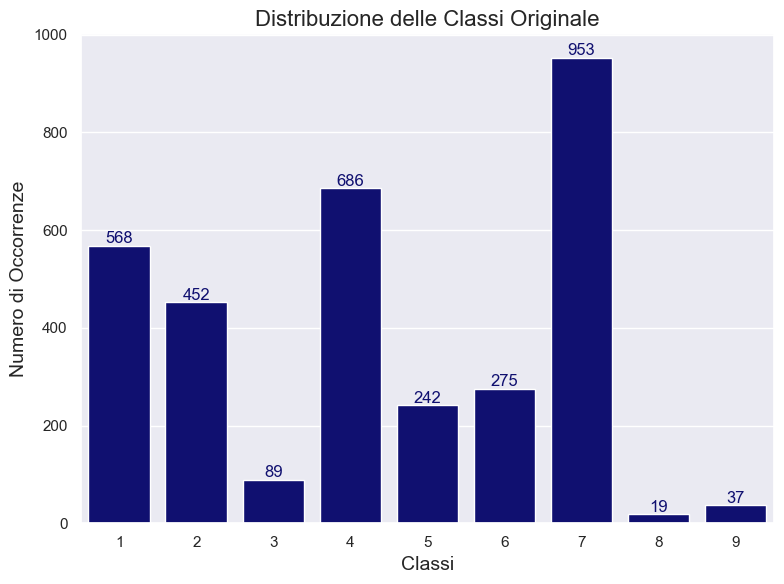

In [6]:
# Distribuzione delle Classi Originale
plot_class_distribution(df, column_name='Class', title='Distribuzione delle Classi Originale', color='navy')

<h2>PRE-PROCESSING DEI DATI</h2>

In [7]:
# Inserimento di altre stop words manualmente adatte al contesto
custom_words = ["fig", "figure", "et", "al", "al.", "also", "data", "analyze", "study", 
                "table", "using", "method", "result", "conclusion", "author", "find", "found", "show"]

# Unione delle stop words di default + la punteggiatura + quelle aggiunte manualmente 
stop_words = set(stopwords.words('english') + list(string.punctuation) + custom_words)

wordnet_lemmatizer = WordNetLemmatizer()

def pre_process(text):
    if isinstance(text, float):
        return ''  # Gestione di valori float
    
    text = str(text).lower().strip()
    
    # Rimozione di punteggiatura, HTML e caratteri speciali
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
    text = re.sub(r'<.*?>+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    # Tokenizzazione, rimozione stopwords e lemmatizzazione
    tokens = word_tokenize(text)
    filtered_tokens = [
        wordnet_lemmatizer.lemmatize(word) for word in tokens 
        if word not in stop_words and not word.isdigit() and len(word) > 1  # ignora parole di lunghezza 1
    ]
    
    return ' '.join(filtered_tokens)



def process_corpus(df, text_column, class_column):
    return df.groupby(class_column).apply(lambda x: Counter(word_tokenize(pre_process(x[text_column].str.cat(sep=' ')))))


In [8]:
# Preprocessing dei dati con barra di avanzamento
print("Preprocessing dei dati...")
df['text'] = [pre_process(text) for text in tqdm(df['text'], desc="Preprocessing")]

Preprocessing dei dati...


Preprocessing: 100%|████████████████████████| 3321/3321 [01:36<00:00, 34.51it/s]


In [9]:
df.head()

,ID,Gene,Variation,Class,text
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinase cdks regulate variety ...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutation monomeric casitas lineage l...


In [10]:
# Cerchiamo righe con valori nulli o con la colonna 'text' vuota
df[df.isnull().any(axis=1) | (df['text'] == '')]

num_righe_mancanti = df[df.isnull().any(axis=1) | (df.select_dtypes(include=['object']).eq('').any(axis=1))].shape[0]
print(f"Numero di righe con feature mancanti o vuote: {num_righe_mancanti}")


Numero di righe con feature mancanti o vuote: 5


In [11]:
# Elimina righe con valori nulli o con campo 'text' vuoto
df = df.dropna(subset=["text"]).loc[df['text'] != '']

num_righe_mancanti = df[df.isnull().any(axis=1) | (df.select_dtypes(include=['object']).eq('').any(axis=1))].shape[0]
print(f"Numero di righe con feature mancanti o vuote dopo Eliminazione: {num_righe_mancanti}")


Numero di righe con feature mancanti o vuote dopo Eliminazione: 0


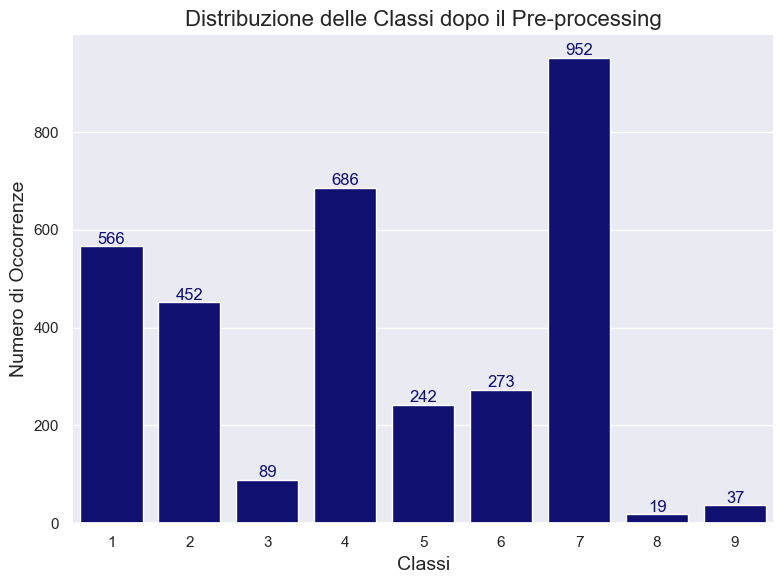

In [12]:
# Distribuzione delle Classi dopo il Pre-processing
plot_class_distribution(df, column_name='Class', title='Distribuzione delle Classi dopo il Pre-processing', color='navy')


In [13]:
df['Class'].value_counts()

Class
7    952
4    686
1    566
2    452
6    273
5    242
3     89
9     37
8     19
Name: count, dtype: int64

<h3> PRE-PROCESSING DEI DATI</h3>

In [14]:
# Separazione delle feature e della target
X_text = df['text']
X_gene_variation = df[['Gene', 'Variation']]
y = df['Class']

In [15]:
# Encoding per Gene e Variation
X_gene_variation_encoded = pd.get_dummies(X_gene_variation, columns=['Gene', 'Variation'])

# Vettorizzazione del testo
tfidf = TfidfVectorizer(max_features=5000)
X_text_vectorized = tfidf.fit_transform(X_text).toarray()

# Applicazione di SVD per la riduzione della dimensionalità
svd = TruncatedSVD(n_components=300)  
X_text_svd = svd.fit_transform(X_text_vectorized)

# Unione delle feature
X = np.hstack([X_text_svd, X_gene_variation_encoded.values])

print(f"Dimensioni delle feature Gene e Variation codificate: {X_gene_variation_encoded.shape}")
print(f"Dimensioni del Testo Vettorializzato: {X_text_svd.shape}")

# Stampa delle dimensioni del dataset finale
print(f"Dimensioni del dataset finale: {X.shape}")

Dimensioni delle feature Gene e Variation codificate: (3316, 3255)
Dimensioni del Testo Vettorializzato: (3316, 300)
Dimensioni del dataset finale: (3316, 3555)


<h2> MODELLAZIONE</h2>

In [16]:
# Definizione parametri per GridSearch con CrossValidazione
def param_grid():
    # Parametri per K-Nearest Neighbors (KNN)
    knn_params = {
        'n_neighbors': [5, 7, 10],  # Numero di vicini
    }
    
    # Parametri per Random Forest (RF)
    rf_params = {
        'n_estimators': [100, 200],  # Numero di alberi nel random forest
        'max_depth': [None, 10, 20],  # Profondità massima degli alberi
    }
    
    # Parametri per XGBoost
    xgb_params = {
        'n_estimators': [100, 200],  # Numero di alberi
        'max_depth': [3, 5],  # Profondità massima degli alberi
    }
    
    return knn_params, rf_params, xgb_params

# Inizializza i parametri
knn_params, rf_params, xgb_params = param_grid()

In [53]:
def train_and_evaluate(model, X_train, X_test, y_train, y_test, param_grid):
   
    # GridSearchCV per ottimizzare i parametri con weighted F1-score
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, 
                               scoring='f1_weighted', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    # Estrazione del miglior modello
    best_model = grid_search.best_estimator_

    # Predizioni sul test set
    y_pred = best_model.predict(X_test)

    # Calcolare precision, recall, F1-score per classe e metriche totali
    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None, labels=np.unique(y_test))
    
    # Calcolare metriche complessive (pesate)
    weighted_metrics = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)

    # Stampa ordinata dei risultati
    print("Risultati della valutazione del modello:")
    print("-" * 50)
    print(f"Accuracy:   {accuracy:.4f}")
    print("\nMetriche per ogni classe:")
    for idx, label in enumerate(np.unique(y_test)):
        print(f"Classe {label}: Precision: {precision[idx]:.4f}, Recall: {recall[idx]:.4f}, F1-Score: {f1[idx]:.4f}, Support: {support[idx]}")
    print("-" * 50)
    print(f"Metriche complessive (pesate):")
    print(f"Precision:  {weighted_metrics[0]:.4f}")
    print(f"Recall:     {weighted_metrics[1]:.4f}")
    print(f"F1-Score:   {weighted_metrics[2]:.4f}")
    print("-" * 50)
    print("Migliori parametri trovati:")
    for param, value in grid_search.best_params_.items():
        print(f"{param}: {value}")
    print("-" * 50)

    # Restituzione dei risultati
    return {
        'per_class': {
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'support': support
        },
        'weighted': {
            'precision': weighted_metrics[0],
            'recall': weighted_metrics[1],
            'f1_score': weighted_metrics[2],
            'accuracy': accuracy
        }
    }, grid_search.best_params_


<h3> CON DATASET ORIGINALE </h3>

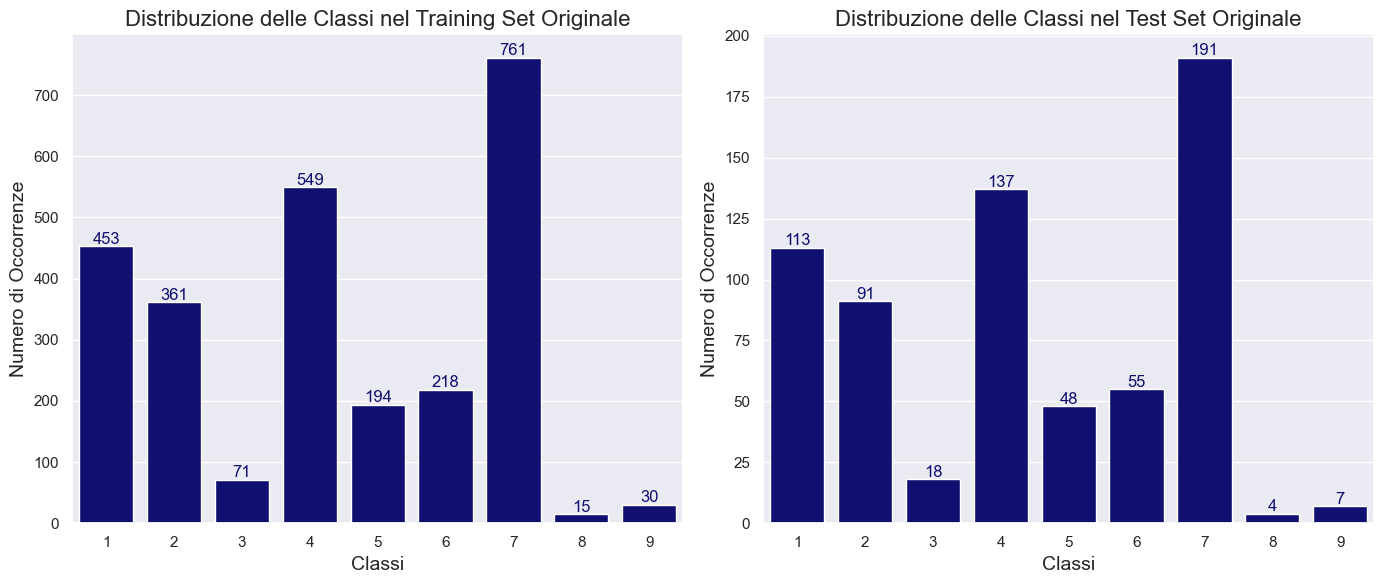

In [22]:
# Separazione in training e test (80-20) mantenendo la stessa distribuzione delle classi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Visualizza la distribuzione delle classi nel training e nel test set
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Grafico per il training set
plot_class_distribution(df=pd.DataFrame({'Class': y_train}), column_name='Class', title='Distribuzione delle Classi nel Training Set Originale', color='navy', ax=axes[0])

# Grafico per il test set
plot_class_distribution(df=pd.DataFrame({'Class': y_test}), column_name='Class', title='Distribuzione delle Classi nel Test Set Originale', color='navy', ax=axes[1])

# Ottimizzazione della disposizione dell'intero layout
plt.tight_layout()
plt.show()

In [54]:
# Chiamata a train_and_evaluate per RandomForestClassifier Originale
results_rf, best_params_rf = train_and_evaluate(
    model=RandomForestClassifier(random_state=42, class_weight='balanced'),
    X_train=X_train, X_test=X_test,
    y_train=y_train, y_test=y_test,
    param_grid=rf_params 
)



Fitting 5 folds for each of 6 candidates, totalling 30 fits
Risultati della valutazione del modello:
--------------------------------------------------
Accuracy:   0.6160

Metriche per ogni classe:
Classe 1: Precision: 0.5377, Recall: 0.5044, F1-Score: 0.5205, Support: 113
Classe 2: Precision: 0.6267, Recall: 0.5165, F1-Score: 0.5663, Support: 91
Classe 3: Precision: 0.3333, Recall: 0.5556, F1-Score: 0.4167, Support: 18
Classe 4: Precision: 0.6917, Recall: 0.6058, F1-Score: 0.6459, Support: 137
Classe 5: Precision: 0.3636, Recall: 0.4167, F1-Score: 0.3883, Support: 48
Classe 6: Precision: 0.8205, Recall: 0.5818, F1-Score: 0.6809, Support: 55
Classe 7: Precision: 0.6696, Recall: 0.7958, F1-Score: 0.7273, Support: 191
Classe 8: Precision: 1.0000, Recall: 0.5000, F1-Score: 0.6667, Support: 4
Classe 9: Precision: 0.6000, Recall: 0.8571, F1-Score: 0.7059, Support: 7
--------------------------------------------------
Metriche complessive (pesate):
Precision:  0.6284
Recall:     0.6160
F1-Sco

<h3> CON DATASET BILANCIATO </h3>

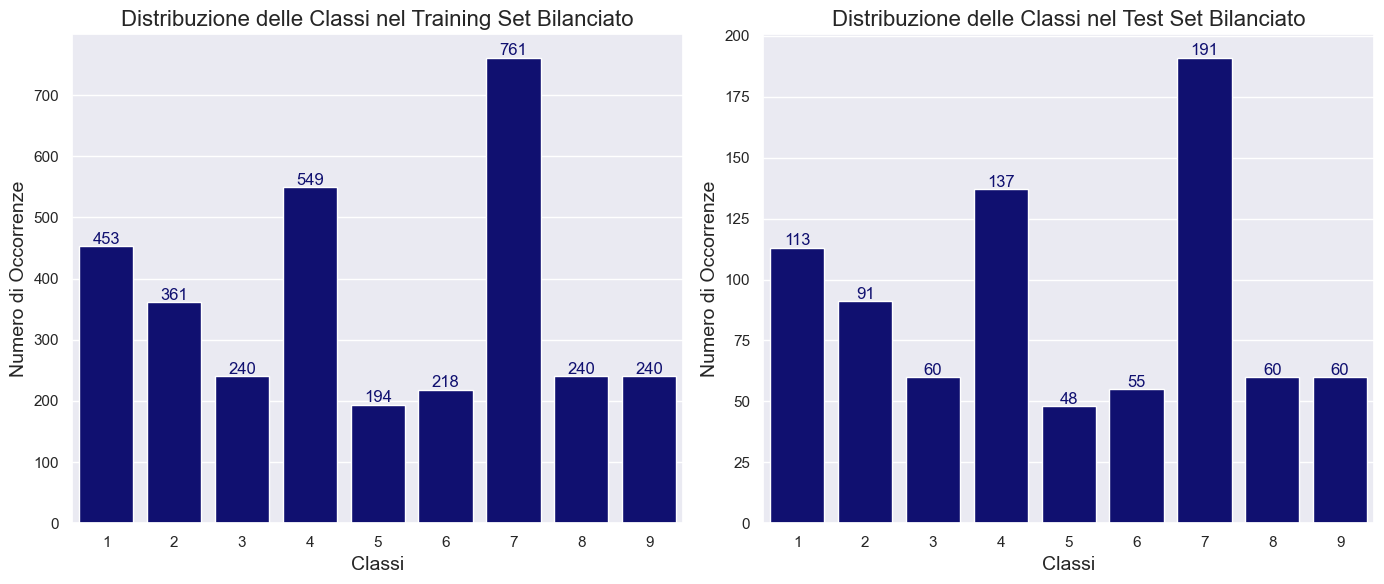

In [43]:
# Definiamo le classi maggioritarie e minoritarie
#classes_to_under = [7, 4]  # Classi da ridurre
classes_to_over = [3, 9, 8]  # Classi da aumentare

# Sottocampionamento delle classi maggioritarie (7, 4, 1) a 400 campioni
#undersampler = RandomUnderSampler(sampling_strategy={7: 650, 4: 650}, random_state=42)
#X_res, y_res = undersampler.fit_resample(X, y)

# Sovracampionamento delle classi minoritarie (3, 9, 8) a 240 campioni con SMOTE
smote = SMOTE(sampling_strategy={3: 300, 9: 300, 8: 300}, random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Separazione in training e test (80-20) mantenendo la stessa distribuzione delle classi
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_res, y_res, test_size=0.2, stratify=y_res, random_state=42)

# Visualizza la distribuzione delle classi nel training e nel test set
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Visualizza la distribuzione delle classi nel training set bilanciato
plot_class_distribution(df=pd.DataFrame({'Class': y_train_balanced}), column_name='Class', title='Distribuzione delle Classi nel Training Set Bilanciato', color='navy', ax=axes[0])

# Visualizza la distribuzione delle classi nel test set bilanciato
plot_class_distribution(df=pd.DataFrame({'Class': y_test_balanced}), column_name='Class', title='Distribuzione delle Classi nel Test Set Bilanciato', color='navy', ax=axes[1])

# Ottimizzazione della disposizione dell'intero layout
plt.tight_layout()
plt.show()

In [55]:
# Chiamata a train_and_evaluate per RandomForestClassifier Originale
results_rf, best_params_rf = train_and_evaluate(
    model=RandomForestClassifier(random_state=42),
    X_train=X_train_balanced, X_test=X_test_balanced,
    y_train=y_train_balanced, y_test=y_test_balanced,
    param_grid=rf_params 
)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Risultati della valutazione del modello:
--------------------------------------------------
Accuracy:   0.7202

Metriche per ogni classe:
Classe 1: Precision: 0.6333, Recall: 0.6726, F1-Score: 0.6524, Support: 113
Classe 2: Precision: 0.5781, Recall: 0.4066, F1-Score: 0.4774, Support: 91
Classe 3: Precision: 0.8103, Recall: 0.7833, F1-Score: 0.7966, Support: 60
Classe 4: Precision: 0.7105, Recall: 0.7883, F1-Score: 0.7474, Support: 137
Classe 5: Precision: 0.4359, Recall: 0.3542, F1-Score: 0.3908, Support: 48
Classe 6: Precision: 0.8649, Recall: 0.5818, F1-Score: 0.6957, Support: 55
Classe 7: Precision: 0.6681, Recall: 0.7906, F1-Score: 0.7242, Support: 191
Classe 8: Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000, Support: 60
Classe 9: Precision: 1.0000, Recall: 0.9833, F1-Score: 0.9916, Support: 60
--------------------------------------------------
Metriche complessive (pesate):
Precision:  0.7193
Recall:     0.7202
F1-S